# Credit Card Fraud Detection
Credit card fraud is one of the most significant challenges facing the financial industry today with losses in the UK amounting to **£551.3 million in 2023 alone**! Fraudulent transactions are rare but highly impactful, making them extremely difficult to detect.

From a machine learning perspective, this presents a **highly imbalanced classification problem**:
- The vast majority of transactions are legitimate.
- Fraudulent transactions make up a very small fraction (**<0.2% in the dataset to be used**).
- A naive model that predicts “not fraud” for everything would achieve 99%+ accuracy, but it would **completely fail at its actual purpose** — detecting fraud.

This project aims to build and evaluate machine learning models that can detect fraudulent transactions with **high recall** (catch as many frauds as possible) while maintaining **precision** (limiting false alarms).

To achieve this, I implemented:
- **Supervised Learning Models** (Logistic Regression, Random Forest, XGBoost and even an ensemble) to learn from labelled fraud cases.
- **Feature Engineering & Threshold Tuning** to optimise my models' performance (in terms of recall, precision and AUC)
- **Cost-Sensitive Learning** to penalise false negatives more heavily, since missing a fraud case is much more costly than flagging a legitimate transaction.

The key business problem:
**How can we detect fraudulent transactions effectively in real-time without overwhelming investigators with too many false positives?**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


***
## Library Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import mannwhitneyu, ks_2samp, chi2_contingency

***
## Data Loading & Initial Exploration 

In [4]:
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


28 of the 31 columns have been anonymised for confidentiality. The remaining 3 columns include:
- `Time`: number of seconds elapsed between each transaction and the first transaction in the dataset.
- `Amount`: quantity of the transaction.
- `Class`: our target variable representing whether the transaction is fraudulent (1) or genuine (0).




In [5]:
df.dtypes.value_counts()

float64    30
int64       1
Name: count, dtype: int64

The target variable `Class` can only take the binary values 1 and 0 making it a categorical variable. All 30 features are numerical so categorical encoding won't be required.

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No missing values so imputation won't be required either.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Here are some observations I made from the table above and the conclusions I came to as a result:

- `Class` mean is **0.001727** → dataset is very imbalanced (only ~0.17% of transactions are fraudulent) → must handle with resampling (**SMOTE/undersampling**) or **cost-sensitive learning**.  
- Consequently, confusion matrix accuracy won't be a reliable metric → better to use **precision, recall, F1-score and AUC**.  

- `Amount` median is **22** & 75% of transactions are **<77** → most purchases are small → fraudsters often test cards with small amounts before large transactions, so **distribution of fraud vs. non-fraud by amount** is worth investigating.  

- The PCA-transformed features have a mean ≈ 0 due to PCA standardisation but their ranges vary significantly → some components capture extreme variations → non-linear models like **XGBoost** will be able to capture relationships better.  

- Some extreme values in PCA features (e.g., **V3, V25**) might be **outliers** worth handling.  
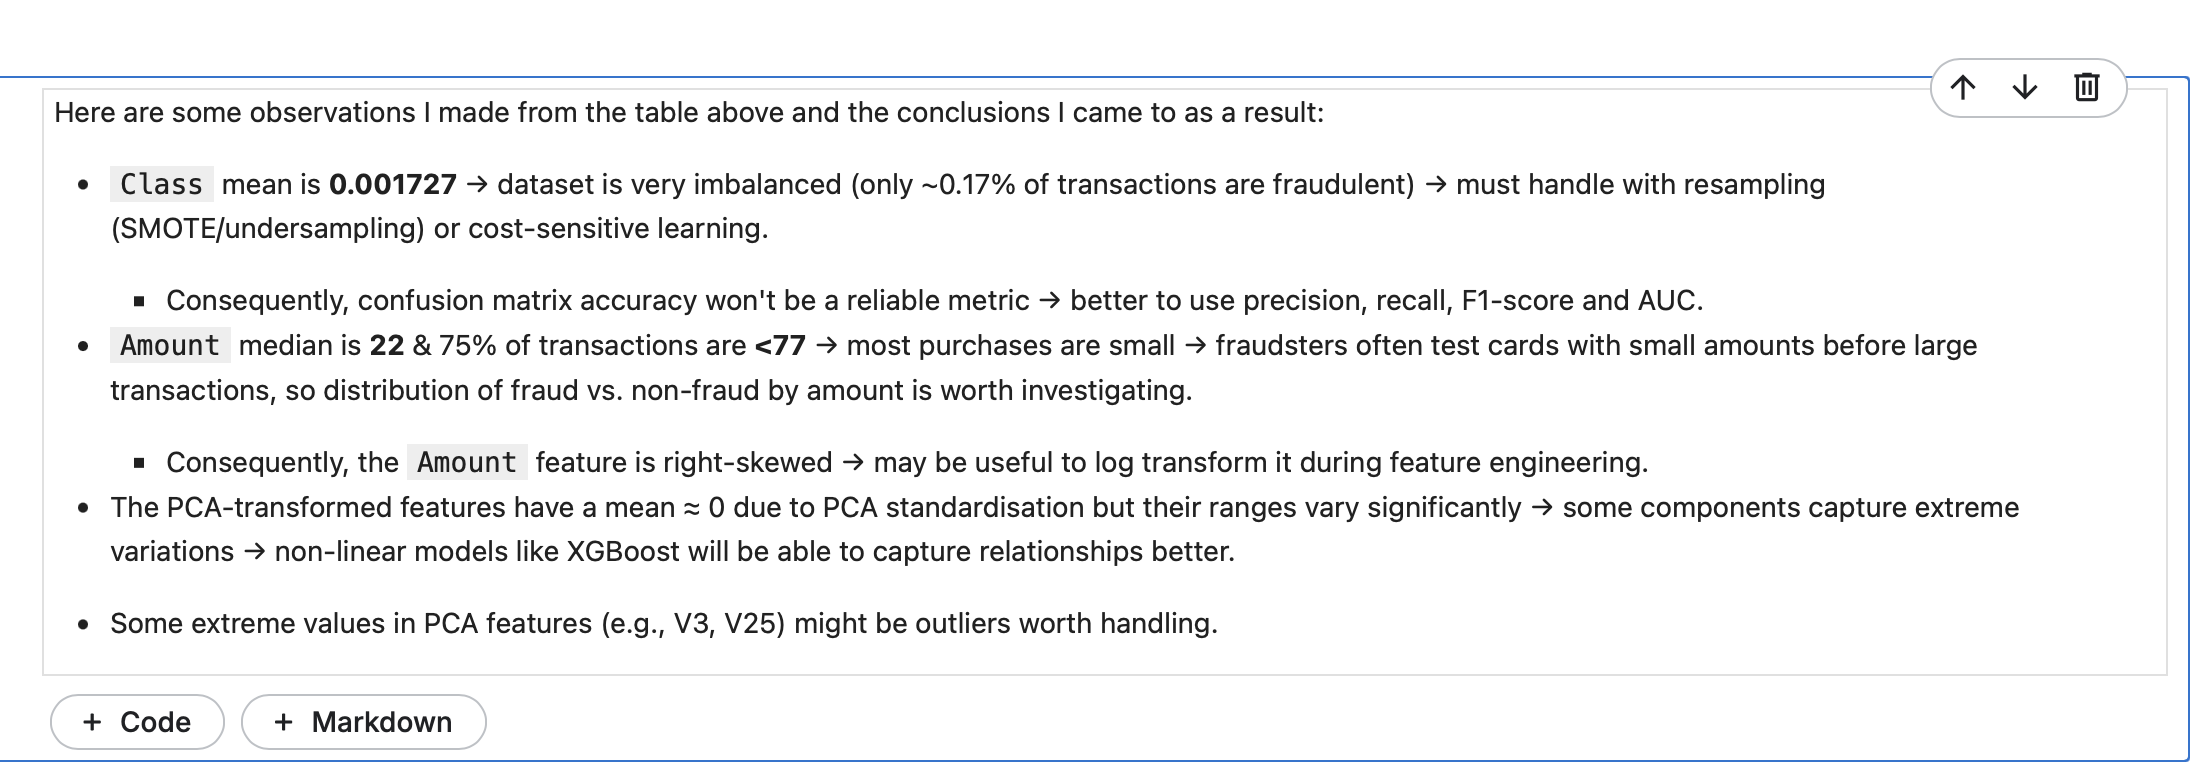

***
## Exploratory Data Analysis (continued)

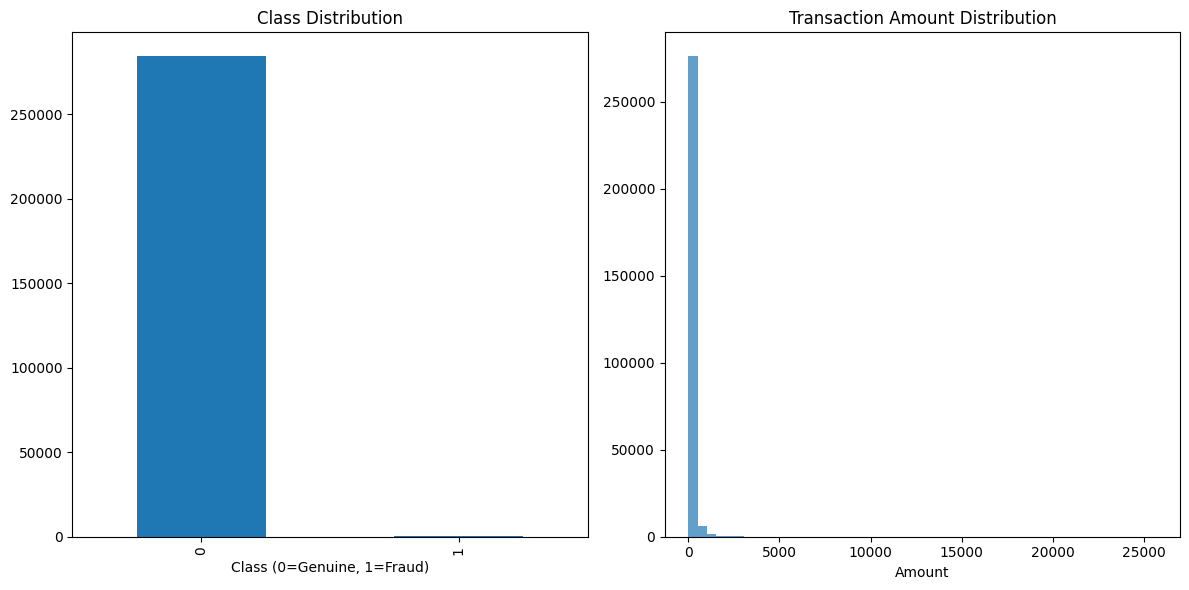

In [8]:
# Class Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0=Genuine, 1=Fraud)')


# Transaction Amount Distribution
plt.subplot(1, 2, 2)
plt.hist(df['Amount'], bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')
plt.tight_layout()
plt.show()

1. Left plot reinforces our findings from the earlier .describe() output; the bar for fraudulent transactions is barely visible.
2. Right plot shows that the `Amount` feature is right-skewed → may be useful to **log transform** it during feature engineering to reduce skewness & stabilise variance → makes models more robust.
<br>
Next, I should investigate the distribution of `Amount` for fraud vs non-fraud classes in order to reveal further important patterns.


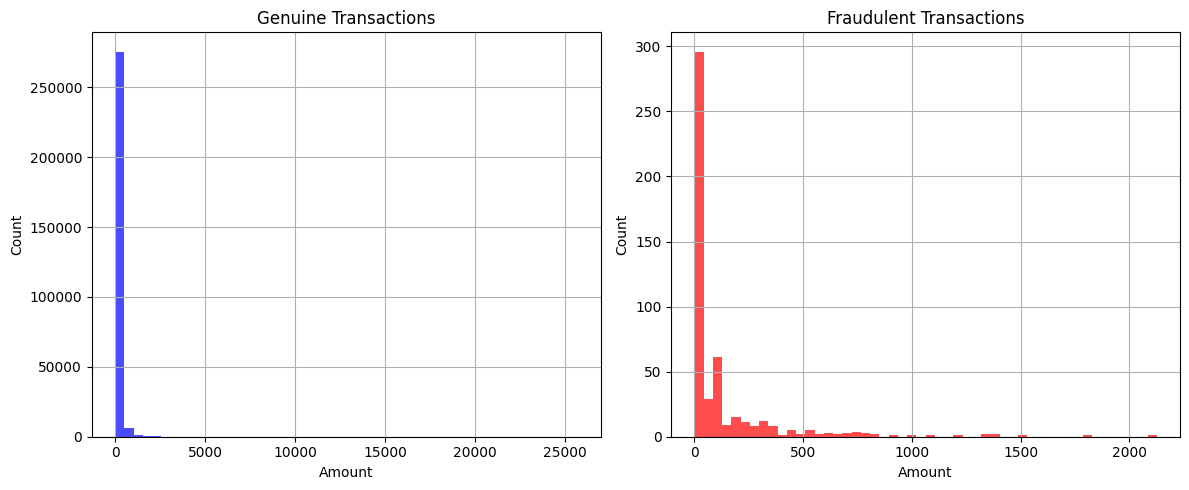

In [9]:
plt.figure(figsize=(12, 5))

# Genuine transactions
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.7, color='blue')
plt.title('Genuine Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

# Fraud transactions
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.7, color='red')
plt.title('Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

	1. Overlap exists between fraud and genuine amounts at small values, so amount alone is not a perfect fraud predictor.
	2. Fraud transactions show more variability and heavier tails → unusual amounts (too small or too large) could signal risk.
	3. A log transformation of Amount could help models distinguish subtle differences between fraud vs genuine transactions.
	4. This observation motivates combining Amount with other features (e.g., PCA features, Time, etc.) for stronger fraud signals.

In [10]:
fraud_amounts = df[df['Class'] == 1]['Amount']
genuine_amounts = df[df['Class'] == 0]['Amount']

# Tests whether distribution of Amount differs significantly between fraud & genuine transactions
stat, p = mannwhitneyu(fraud_amounts, genuine_amounts, alternative='two-sided')
print(f"Mann–Whitney U Test: statistic={stat}, p-value={p}")

# Compares entire distributions of both samples
stat, p = ks_2samp(fraud_amounts, genuine_amounts)
print(f"K-S Test: statistic={stat}, p-value={p}")

Mann–Whitney U Test: statistic=61833399.0, p-value=8.578472310840218e-06
K-S Test: statistic=0.27119151307757383, p-value=2.1703053464297685e-32


To statistically verify the difference, I conducted the **Mann–Whitney U test** and the **Kolmogorov–Smirnov test**. Both tests yielded **p-values < 0.001**, confirming that transaction amounts for fraud and genuine transactions follow **significantly** different distributions. This supports our earlier visualisation and highlights `Amount` as a valuable predictive feature (particularly after log transformation).

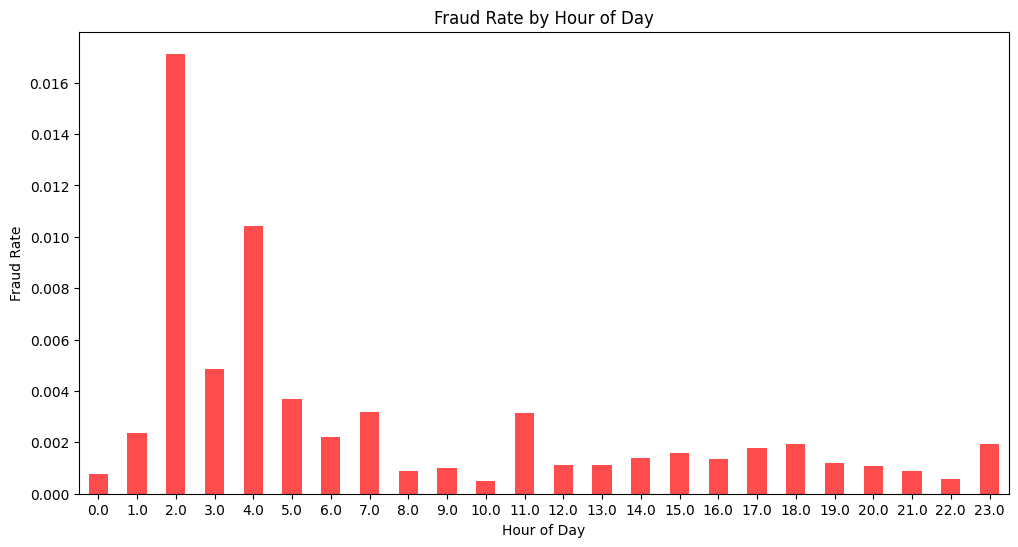

In [11]:
# Create 'Hour' feature from 'Time' (seconds → hours)
df['Hour'] = (df['Time'] // 3600) % 24  # modulo 24 to wrap around daily cycle

# Fraud rate per hour
hourly_fraud_rate = df.groupby('Hour')['Class'].mean()

# Plot
plt.figure(figsize=(12,6))
hourly_fraud_rate.plot(kind='bar', color='red', alpha=0.7)
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.show()

- Fraudulent transactions are **not evenly distributed** over time — they cluster heavily during the early morning hours (**2–4 AM**). This pattern could suggest:
	- Fraudsters may attempt transactions at times when victims are less likely to notice (e.g. asleep).
	- Or it could reflect systematic vulnerabilities in processing/monitoring at those hours.
- Time of day could therefore be a useful feature in my model, either directly (e.g. Hour) or in interaction with other variables like `Amount`.
To determine whether the correlation between `Time` and `Class` is statistically significant and verify my findings, I will carry out a Chi-Square test. 


In [12]:
# Create contingency table: rows=Hour, cols=Class (0=Normal, 1=Fraud)
contingency_table = pd.crosstab(df['Hour'], df['Class'])

# Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Interpretation
if p < 0.05:
    print("❌ Reject H0: Fraud distribution IS dependent on hour (fraud patterns vary by time).")
else:
    print("✅ Fail to reject H0: No strong evidence that fraud depends on hour.")

Chi-Square Statistic: 674.4434008593606
Degrees of Freedom: 23
P-value: 1.0660029339084448e-127
❌ Reject H0: Fraud distribution IS dependent on hour (fraud patterns vary by time).


invalid value encountered in less


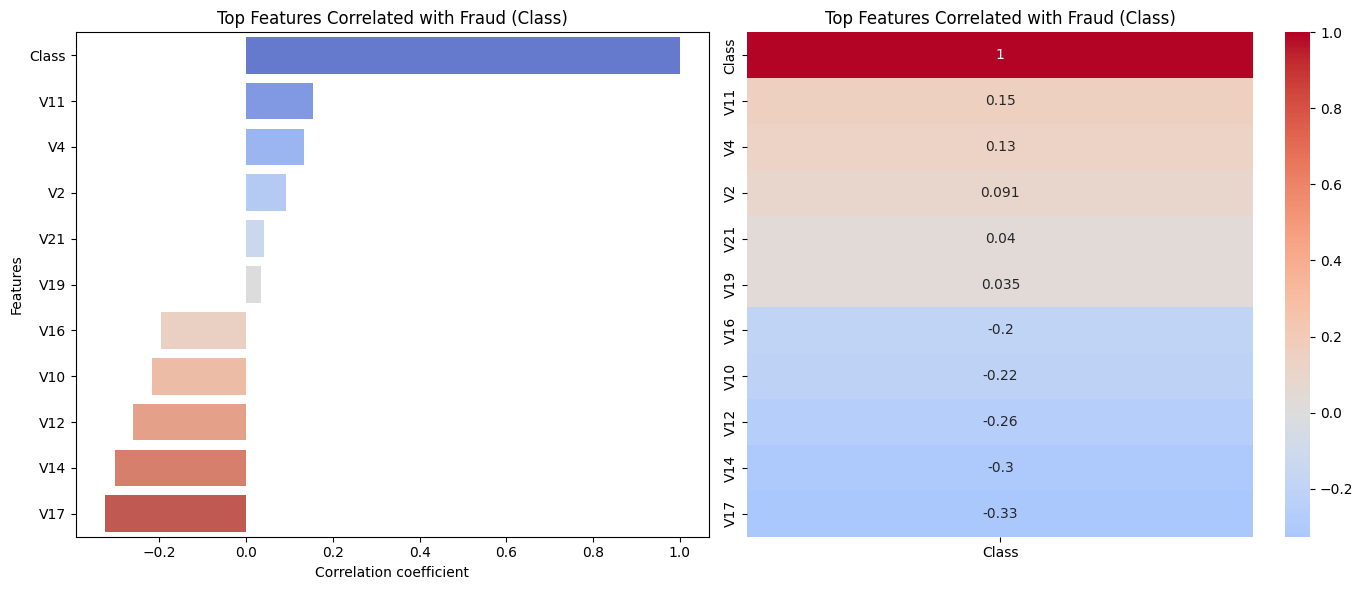

In [13]:
# Compute correlations with 'Class'
correlations = df.corr()['Class'].sort_values(ascending=False)

# Select top 5 positive and top 5 negative correlations
top_features = pd.concat([correlations.head(6), correlations.tail(5)])

plt.figure(figsize=(14,6))

# Barplot
plt.subplot(1, 2, 1)
sns.barplot(x=top_features.values, y=top_features.index, palette="coolwarm")
plt.title("Top Features Correlated with Fraud (Class)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

# Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(top_features.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title("Top Features Correlated with Fraud (Class)")

plt.tight_layout()
plt.show()

The features with the strongest absolute correlation with `Class` are:
- `V17`
- `V14`
- `V12`
- `V11`
- `V10`
- `V4`

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

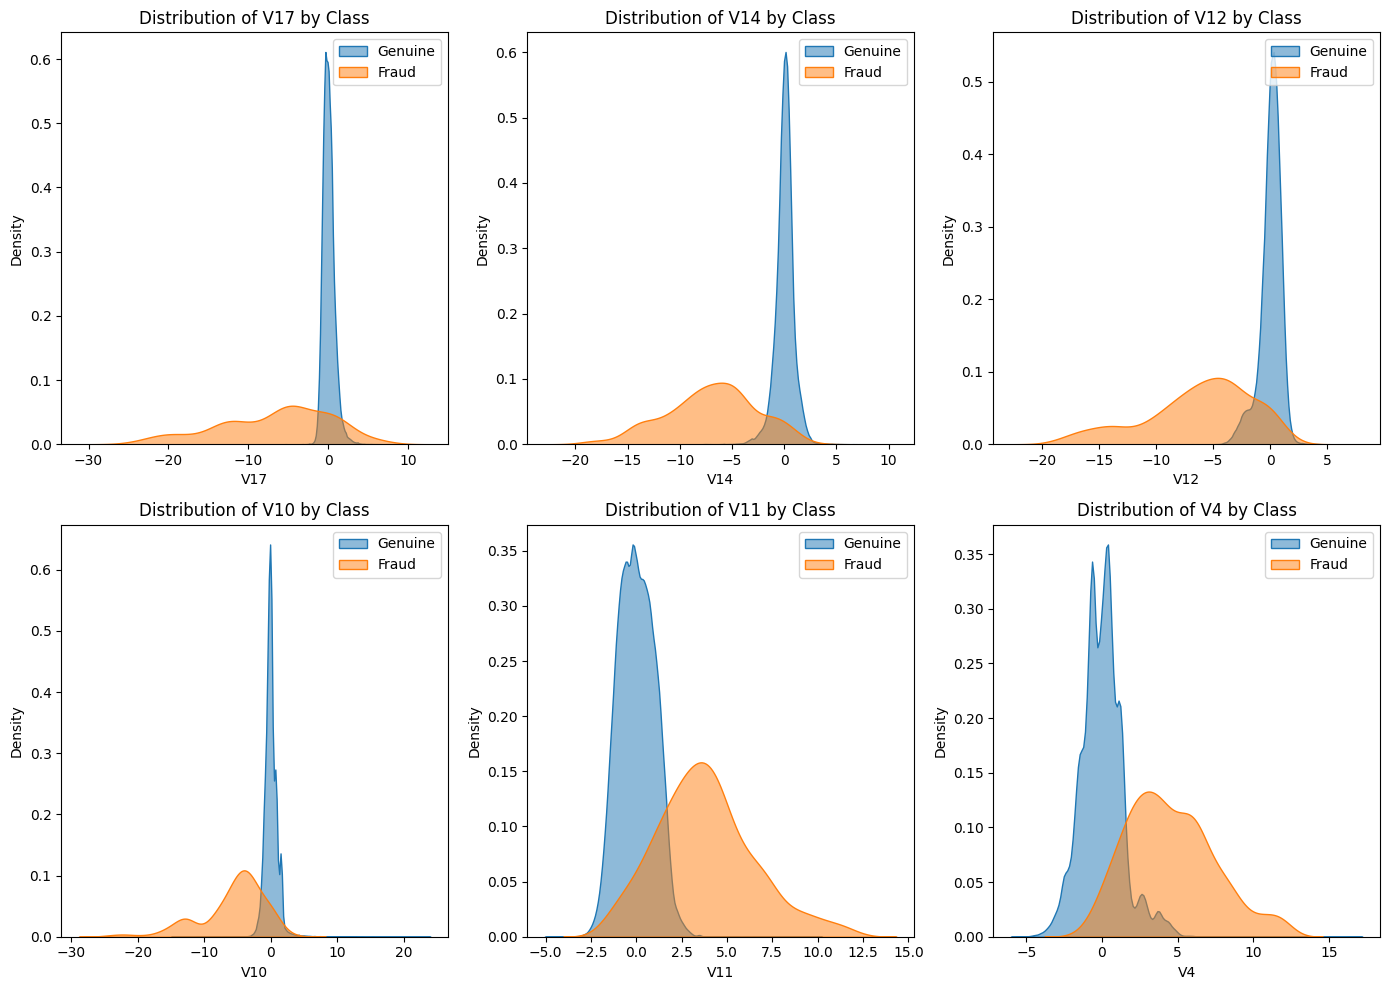

In [14]:
top_features = ['V17', 'V14', 'V12','V10','V11','V4'] 

plt.figure(figsize=(14, 10))
for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=df[df['Class'] == 0], x=feature, label="Genuine", fill=True, alpha=0.5)
    sns.kdeplot(data=df[df['Class'] == 1], x=feature, label="Fraud", fill=True, alpha=0.5)
    plt.title(f"Distribution of {feature} by Class")
    plt.legend()
plt.tight_layout()
plt.show()

- Fraudulent transactions generally produce **broader, shifted distributions**, while genuine transactions cluster tightly around 0. 
- Features **V17, V14, V12, V10** are particularly powerful fraud indicators → they show clear separation and could be prioritised in feature selection.
- Because the distributions differ so distinctly, **non-linear models** (XGBoost, Random Forest, Neural Nets) will likely exploit these differences more effectively than purely linear models.

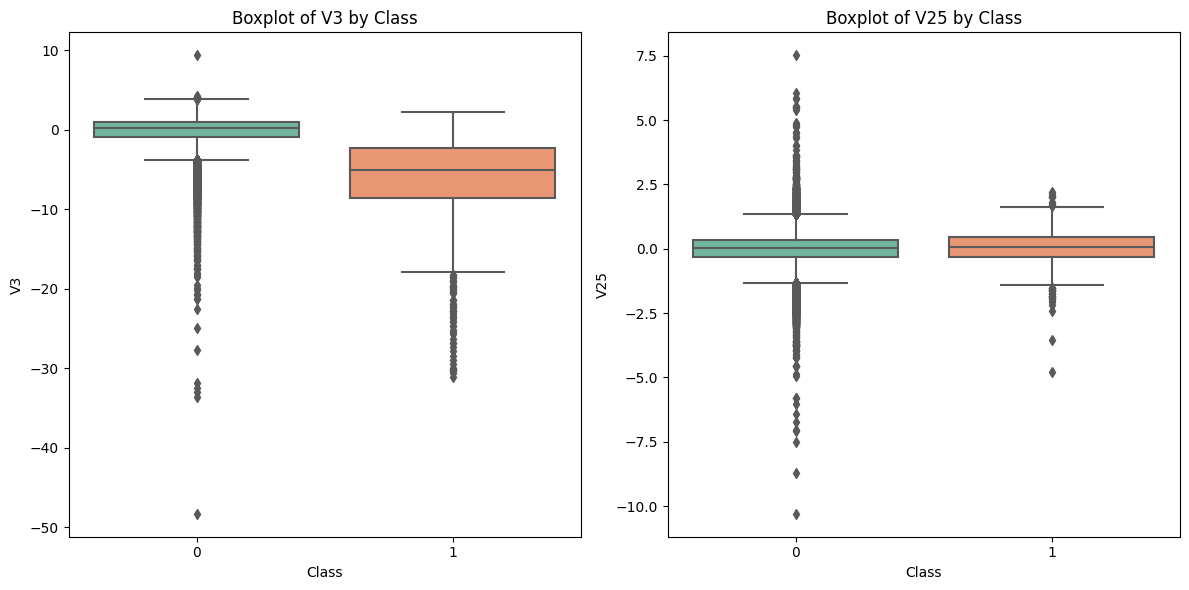

In [15]:
features_to_check = ['V3', 'V25'] # features I found to have extreme values in previous section

plt.figure(figsize=(12,6))
for i, feature in enumerate(features_to_check, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x='Class', y=feature, data=df, palette="Set2")
    plt.title(f"Boxplot of {feature} by Class")
plt.tight_layout()
plt.show()

**V3** (left plot):
- For genuine transactions (Class = 0), the distribution of V3 is **centred around 0** but has many extreme **negative outliers**.
- For fraudulent transactions (Class = 1), the **median is lower** and the **interquartile range is shifted downward** compared to genuine transactions.

⸻

**V25** (right plot):
- For genuine transactions, V25 is tightly **distributed around 0**, with a few outliers in both directions.
- For fraudulent transactions, the **median is slightly higher than 0**, with **more spread** in the distribution.

***
## Feature Engineering
Through research about the domain and some general knowledge, I was able to derive the following features that may be able to improve the model's performance:

In [16]:
df_features = df.copy()

# Custom features derived from Amount
df_features['Log_Amount'] = np.log1p(df_features['Amount']) # less useful for xgboost compared to logistic regression
amount_counts = df['Amount'].value_counts()
df_features['Amount_Frequency'] = df_features['Amount'].map(amount_counts).fillna(1)
df_features['Amount_Rarity'] = 1 / (df_features['Amount_Frequency'] + 1)
df_features['Rolling_Amount_Mean'] = df_features['Amount'].rolling(window=100, min_periods=1).mean() # proxy for sudden anomalies

# Interaction features 
df_features['V1_V2_Prod'] = df_features['V1'] * df_features['V2']
df_features['V1_V3_Ratio'] = df_features['V1'] / (df_features['V3'] + 1e-8)
df_features['V14_V12_Sum'] = df_features['V14'] + df_features['V12']
df_features['V10_V11_Diff'] = df_features['V10'] - df_features['V11']
df_features['V17_Abs'] = df_features['V17'].abs()
df_features['V4_Sq'] = df_features['V4'] ** 2
df_features['V14_V4_Prod'] = df_features['V14'] * df_features['V4']

In [17]:
# Train-test split
X = df_features.drop(columns=['Class'])
y = df_features['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=42)

Next, I will conduct a SHAP feature analysis to find out whether my newly engineered features positively impact the model or not. I have chosen to use xgboost with default parameters because it is fast to train, doesn't require scaling and it handles non-linear interactions well. I will go into much further depth with this model in a future section.

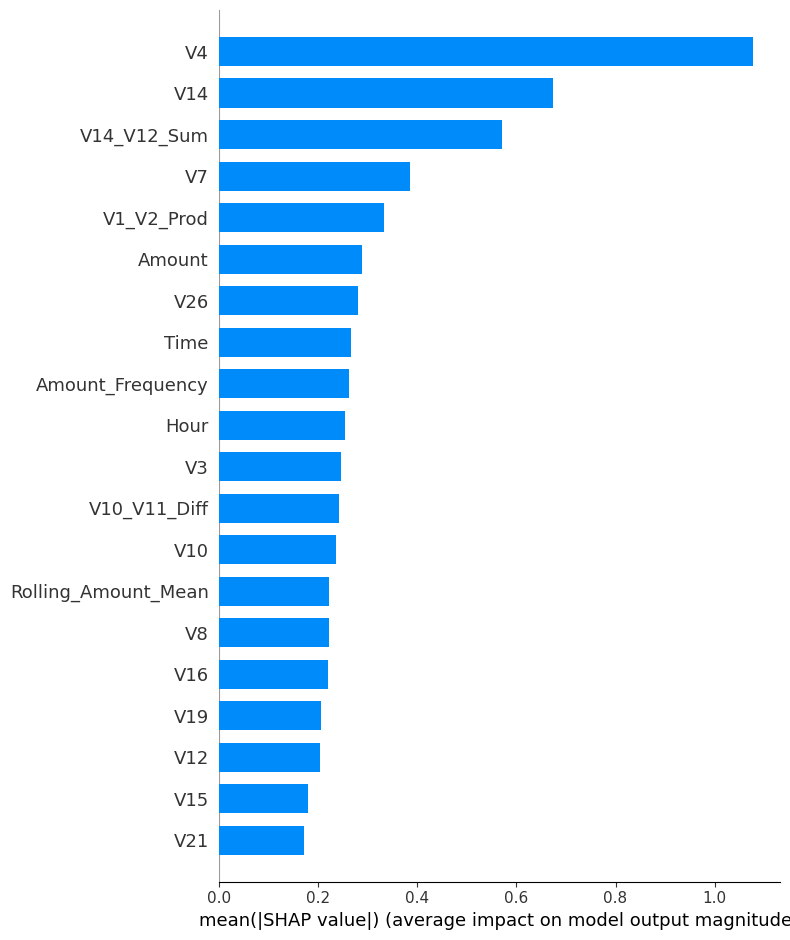

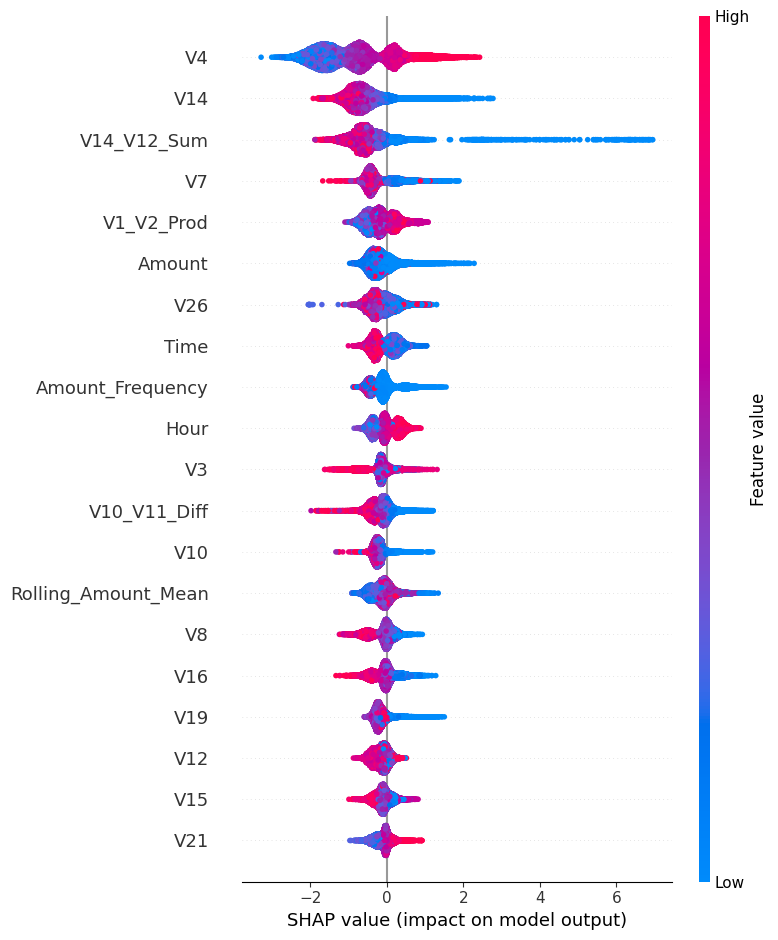

In [18]:
# Model trained on enhanced dataset
xgb_enhanced = XGBClassifier(random_state=42)
engineered_cols = [col for col in df_features.columns if col not in ['Class']]
xgb_enhanced.fit(X_train[engineered_cols], y_train)

# SHAP explainer
explainer = shap.TreeExplainer(xgb_enhanced)
shap_values = explainer.shap_values(X_test)

# Global importance plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed summary (shows feature impact direction too)
shap.summary_plot(shap_values, X_test)

From the SHAP feature analysis, I noticed that:
- `V4` is the single **most predictive** feature.
- Feature engineering worked well with `V14_V12_Sum`, `V1_V2_Prod` and `V10_V11_Diff` all ranking in the top features, proving that **combining PCA components captures meaningful patterns**.
- `Amount` has low importance, indicating **transaction amounts alone aren't strong fraud predictors** -> validates use of my amount-based engineered features.
- While the model performs well, **explaining fraud decisions to business stakeholders may be difficult** since the most important features are PCA-transformed components rather than intuitive business metrics.
<br>
<br>
Now, I will calculate different metrics like AUC, recall and f1-score to quantify the improvements made through feature engineering. 

In [19]:
# Baseline using only original columns
original_cols = [col for col in df.columns if col not in ['Class']]

xgb_baseline = XGBClassifier(random_state=42)
xgb_baseline.fit(X_train[original_cols], y_train)
baseline_preds = xgb_baseline.predict(X_test[original_cols])
baseline_auc = roc_auc_score(y_test, baseline_preds)

# Enhanced using original + feature engineering columns
enhanced_preds = xgb_enhanced.predict(X_test[engineered_cols])
enhanced_auc = roc_auc_score(y_test, enhanced_preds)

# Results
print(f"Baseline AUC:  {baseline_auc:.4f}")
print("\nClassification Report (Baseline):")
print(classification_report(y_test, baseline_preds, digits=4,target_names=['Not Fraud', 'Fraud']))
print(f"\nEnhanced AUC:  {enhanced_auc:.4f}")
print("\nClassification Report (Enhanced):")
print(classification_report(y_test, enhanced_preds, digits=4,target_names=['Not Fraud', 'Fraud']))

Baseline AUC:  0.9132

Classification Report (Baseline):
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9999    0.9998     56864
       Fraud     0.9101    0.8265    0.8663        98

    accuracy                         0.9996     56962
   macro avg     0.9549    0.9132    0.9330     56962
weighted avg     0.9995    0.9996    0.9996     56962


Enhanced AUC:  0.9234

Classification Report (Enhanced):
              precision    recall  f1-score   support

   Not Fraud     0.9997    0.9999    0.9998     56864
       Fraud     0.9326    0.8469    0.8877        98

    accuracy                         0.9996     56962
   macro avg     0.9662    0.9234    0.9438     56962
weighted avg     0.9996    0.9996    0.9996     56962



The results show the feature engineering improved the model's performance, with the enhanced model having a:
- **Higher AUC** (0.9234 > 0.9132) → better overall discrimination.
- **Higher Precision** (0.9326 > 0.9101) → less legitimate transactions flagged as fraud.
- **Higher Recall** (0.8469 > 0.8265) → catches more actual fraud cases.
- **Higher f1-score** (0.8877 > 0.8663) → better balance of precision + recall.

***
## Class Imbalance Treatment Strategies
As mentioned earlier, one of the key challenges with fraud detection datasets is the sheer imbalance between genuine and fraudulent cases. To address this, I will compare a baseline with 2 sampling techniques to ensure the model pays proper attention to the minority class:
- **Undersampling**: Randomly reduce the number of non-fraud cases to balance the dataset → prevents model from being overwhelmed by the majority class, but comes at the cost of losing some information.
- **SMOTE**: Generate synthetic fraud samples by interpolating between existing fraud cases → helps balance dataset without discarding genuine data.
<br>

I will be using a **logistic regression model** to test the sampling techniques so I will first scale `X_train` and `X_test`.

In [20]:
# Scale data for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [21]:
# Apply sampling to scaled data
resampled = {}
resampled['baseline'] = (X_train_scaled, y_train)

# Undersampling
rus = RandomUnderSampler(sampling_strategy=0.05, random_state=42)  
resampled['undersample'] = rus.fit_resample(X_train_scaled, y_train)

# SMOTE
smote = SMOTE(sampling_strategy=0.05, random_state=42)  
resampled['smote'] = smote.fit_resample(X_train_scaled, y_train)

# Evaluation
for method, (X_sampled, y_sampled) in resampled.items():
    print(f"\nTraining with {method.upper()}...")
    print(f"Training set size: {len(X_sampled)}, Fraud %: {y_sampled.mean():.3f}")
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_sampled, y_sampled)
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    print(f"AUC Score: {roc_auc_score(y_test, y_prob):.2f}")
    print(classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud']))


Training with BASELINE...
Training set size: 227845, Fraud %: 0.002
AUC Score: 0.97
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.84      0.69      0.76        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962


Training with UNDERSAMPLE...
Training set size: 8274, Fraud %: 0.048
AUC Score: 0.97
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.45      0.89      0.60        98

    accuracy                           1.00     56962
   macro avg       0.72      0.94      0.80     56962
weighted avg       1.00      1.00      1.00     56962


Training with SMOTE...
Training set size: 238823, Fraud %: 0.048
AUC Score: 0.97
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00     

The results show that sampling was successful with a much **higher percentage of fraud** in the resampled datasets versus the baseline. This resulted in a major **increase to recall** (our most valuable metric) as well as a slight **increase in AUC**. This was at the cost of precision and f1-score, though these metrics are **less valuable** as false negatives are much more costly than false positives. In addition to this, I can use **threshold tuning** to balance out recall and precision if needed. Overall, **SMOTE proved to be the best sampling strategy.**

***
## Supervised Learning Models
In this section, I will train 2 models: a random forest classifier & XGBoost. Tree-based models are affected differently by sampling to simpler models like KNN and Logistic Regression. It is often better to use cost-sensitive learning techniques (class_weight='balanced' and scale_pos_weight) instead of resampling, as random forest and xgboost can natively handle imbalance more effectively. Therefore, I will compare their performance with and without sampling. Since these models don't require scaling beforehand (unlike logistic regression), I will also have to carry out SMOTE sampling again - this time on the raw training data.

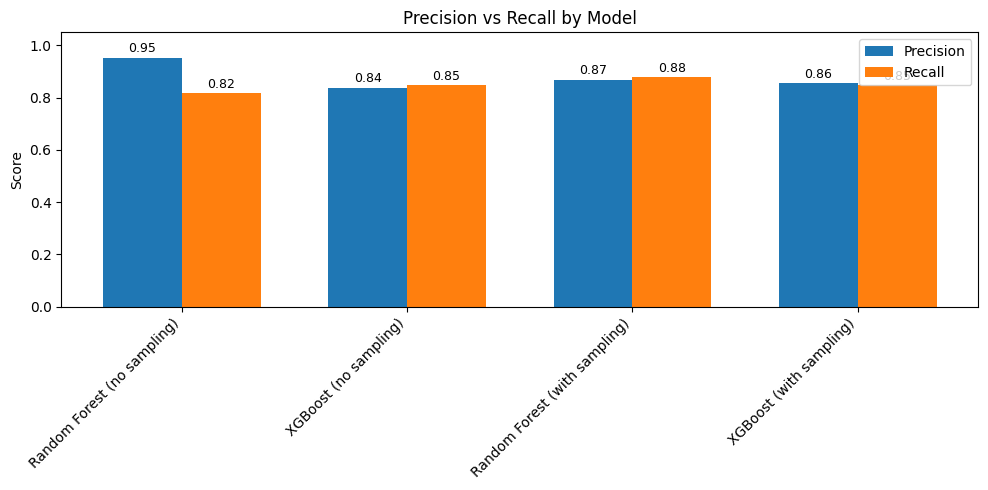

In [22]:
# 1. Resample
smote = SMOTE(sampling_strategy=0.05, random_state=42)  
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 2. Train Models & Collect Metrics
results = []
models = {
    "Random Forest (no sampling)": RandomForestClassifier(random_state=42),
    "XGBoost (no sampling)": XGBClassifier(random_state=42, scale_pos_weight=2800),
    "Random Forest (with sampling)": RandomForestClassifier(random_state=42),
    "XGBoost (with sampling)": XGBClassifier(random_state=42)
}

for label, model in models.items():
    model.fit(X_train if "no sampling" in label else X_train_resampled,
              y_train if "no sampling" in label else y_train_resampled)

    y_pred = model.predict(X_test)

    results.append({
        "Model": label,
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1)
    })

# 3. Convert to DataFrame
results_df = pd.DataFrame(results)

# 4. Plot
plt.figure(figsize=(10, 5))
x = range(len(results_df))
width = 0.35

# Bars
prec_bars = plt.bar([i - width/2 for i in x], results_df["Precision"], width=width, label="Precision")
recall_bars = plt.bar([i + width/2 for i in x], results_df["Recall"], width=width, label="Recall")

# Add value labels
for bar_group in [prec_bars, recall_bars]:
    for bar in bar_group:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                 f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.xticks(x, results_df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Precision vs Recall by Model")
plt.legend()
plt.tight_layout()
plt.show()

As seen from the above bar graph, random forest without sampling has the highest precision, but lacks in recall (our most important metric). Random forest with sampling resolves this issue and has the highest recall of any model. Xgboost performs better without sampling as expected and is the best model overall. On the other hand, random forest performs better with sampling. This is because:
- Before SMOTE, the RF model underfit the minority class (fraud) -> extremely high precision, mediocre recall in comparison.
- After SMOTE, the RF model had enough balanced data to recognise more fraudulent patterns.
- The slight risk of noise introduced by synthetic samples was outweighed by the improved minority class representation.

I am aiming to get the recall and precision scores to ~ 0.9. None of my models so far can do this (though random forest with sampling is close) so I will now create a soft voting ensemble to benefit from the different strengths of each model.

In [23]:
xgb_model = models["XGBoost (no sampling)"]
rf_smote = models["Random Forest (with sampling)"]
rf_base = models["Random Forest (no sampling)"]

# Get probability predictions from each model
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
rf_smote_probs = rf_smote.predict_proba(X_test)[:, 1]
rf_base_probs = rf_base.predict_proba(X_test)[:, 1]

# Weighted average
ensemble_probs = (
    0.1 * xgb_probs +         
    0.2 * rf_smote_probs +     
    0.7 * rf_base_probs    
)

# Threshold tuning
def find_best_threshold(y_true, y_prob, min_recall=0.9, min_precision=0.8):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # Try to meet both targets
    valid_mask = (recalls[:-1] >= min_recall) & (precisions[:-1] >= min_precision)
    
    if np.any(valid_mask):
        # Found threshold meeting both targets
        idx = np.where(valid_mask)[0][0]
        best_threshold = thresholds[idx]
        print(f"✓ Found threshold meeting both targets: {best_threshold:.3f}")
    else:
        # Find best compromise using F1 score
        f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
        idx = np.argmax(f1_scores)
        best_threshold = thresholds[idx]
        print(f"⚠ No threshold meets both targets. Using best F1 threshold: {best_threshold:.3f}")
    
    return best_threshold, precisions[idx], recalls[idx]

# Run the function
best_threshold, best_precision, best_recall = find_best_threshold(
    y_test, ensemble_probs, min_recall=0.9, min_precision=0.8
)

# Make predictions with optimal threshold
ensemble_preds = (ensemble_probs >= best_threshold).astype(int)

# Evaluate model
print("ENSEMBLE MODEL RESULTS:")
print(f"Optimal Threshold: {best_threshold:.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, ensemble_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_preds, target_names=['Not Fraud', 'Fraud']))

⚠ No threshold meets both targets. Using best F1 threshold: 0.422
ENSEMBLE MODEL RESULTS:
Optimal Threshold: 0.422
AUC-ROC: 0.9782

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.91      0.88      0.89        98

    accuracy                           1.00     56962
   macro avg       0.95      0.94      0.95     56962
weighted avg       1.00      1.00      1.00     56962



The ensemble seems to have been a success! After spending some time adjusting the ratios to which each model makes up the ensemble, I was able to reach a precision of 0.91 and a recall of 0.88 - beating out any individual model.
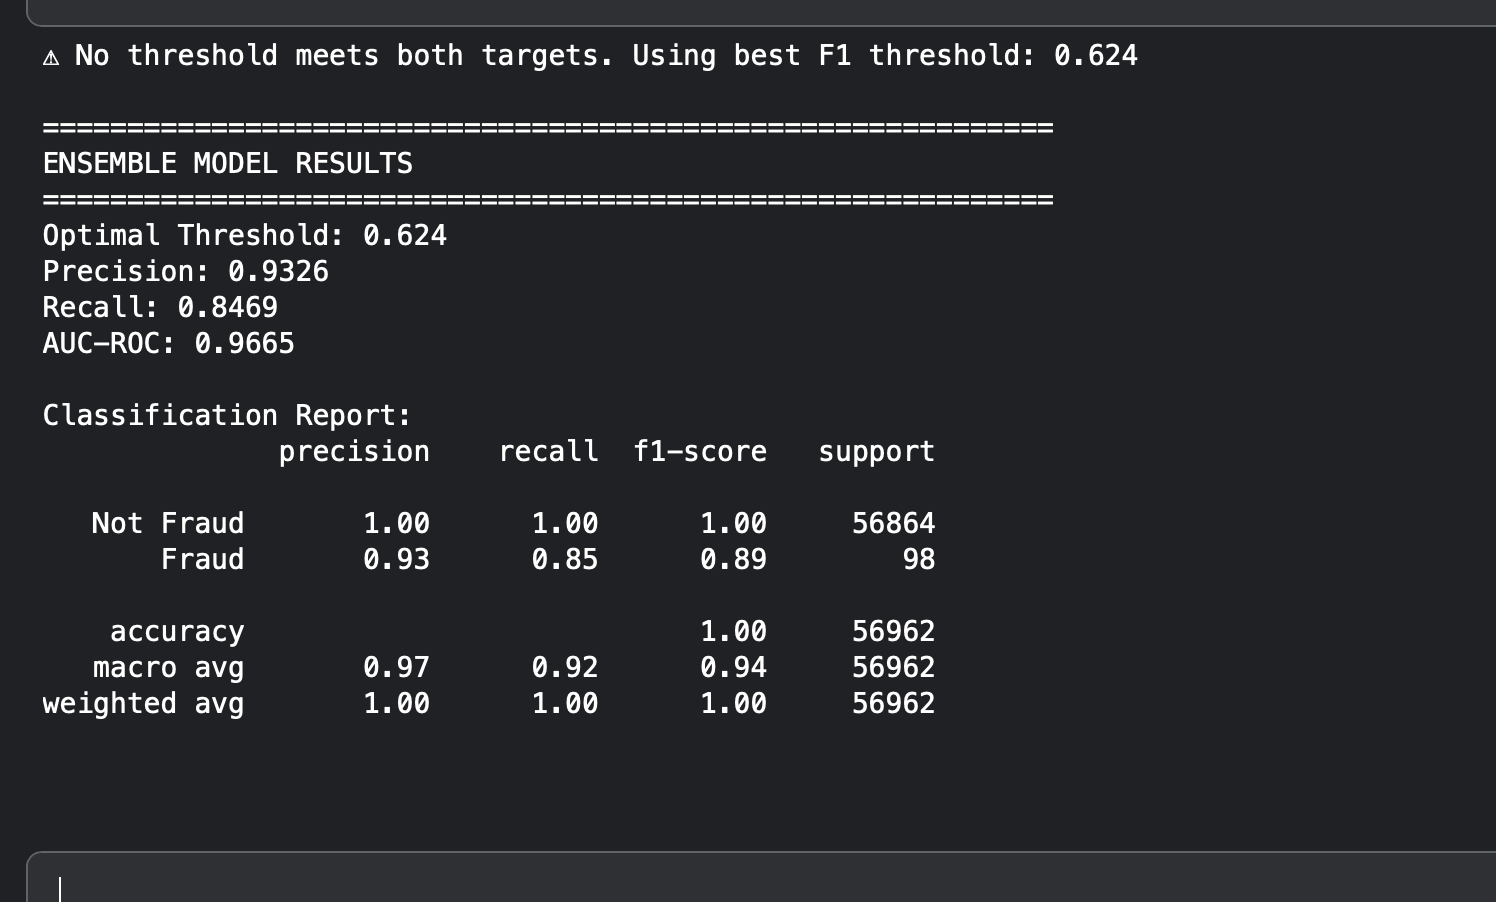
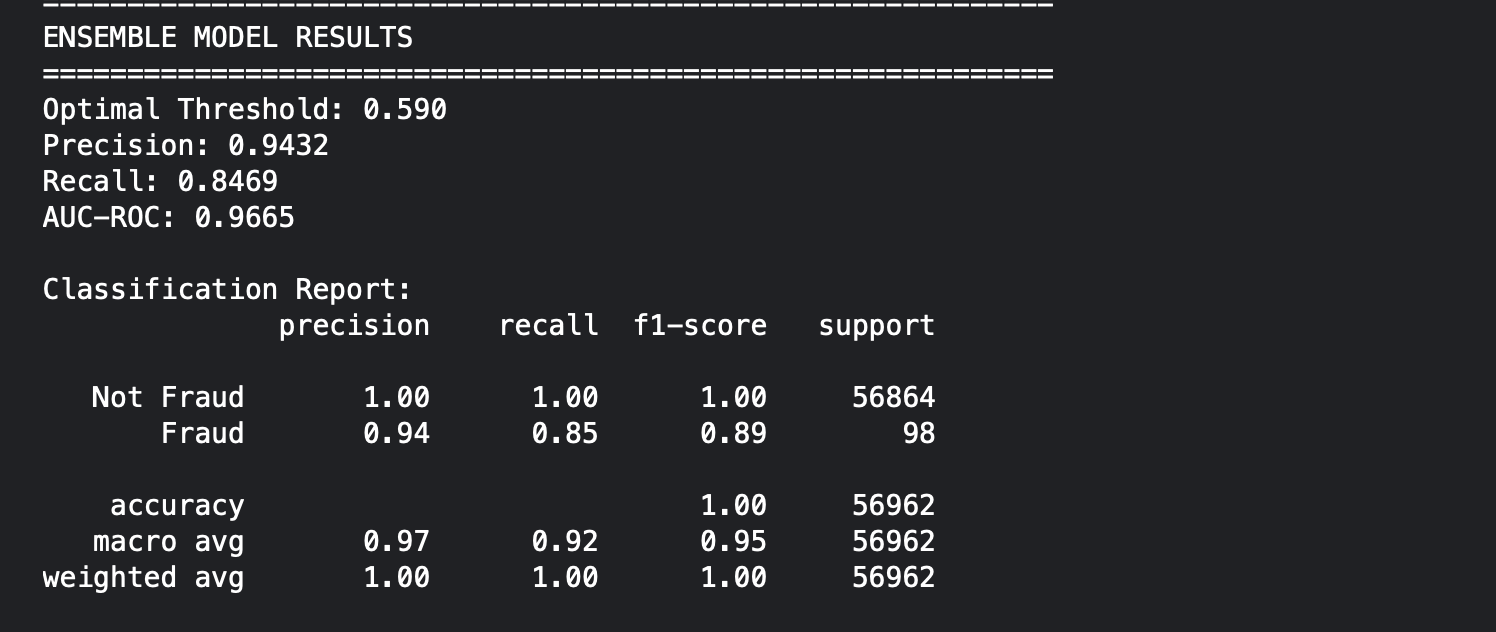

***
## Business Analytics
The following 2 cells show the number of genuine (0) vs fraudulent (1) transactions and their average amount in euros, respectively. I will use this information throughout this section to calculate my model's performance from a business perspective. I will also assume the cost to investigate one flagged transaction to be **€15**.

In [25]:
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [24]:
df.groupby("Class")["Amount"].mean()

Class
0     88.291022
1    122.211321
Name: Amount, dtype: float64

<Figure size 500x400 with 0 Axes>

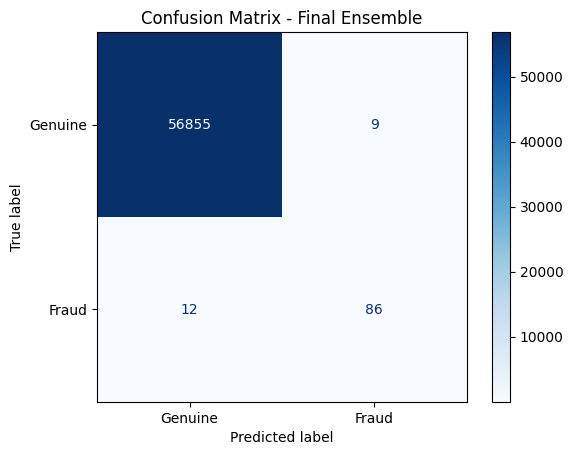

In [26]:
# CONFUSION MATRIX

cm = confusion_matrix(y_test, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Genuine', 'Fraud'])
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Ensemble")
plt.show()

The confusion matrix shows that the ensemble model correctly identifies **86 of 98 fraud cases** while only producing **9 false positives**. This prevents €10,510 in fraud at an investigation cost of just €1,425 (95 cases × €15), while missing only €1,467 in undetected fraud, delivering a **net benefit of €7,618 per period**. The 0.17% flagging rate (95 cases from 56,962 transactions) ensures minimal customer friction, with only **9 innocent cardholders** experiencing verification requests while the system efficiently targets high-value fraudulent transactions averaging **€122 per case**.

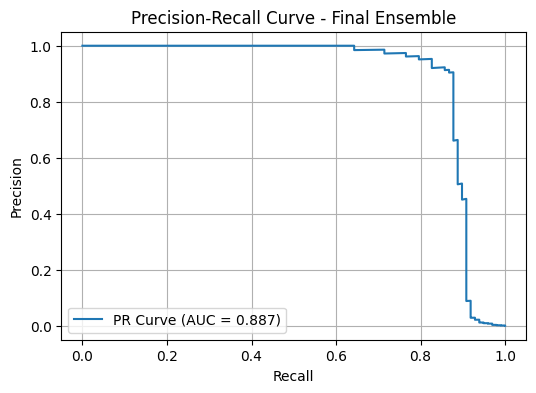

In [29]:
# PRECISION-RECALL CURVE

precisions, recalls, thresholds = precision_recall_curve(y_test, ensemble_probs)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Final Ensemble')
plt.grid(True)
plt.legend()
plt.show()

The precision-recall curve reveals three viable operating strategies: ultra-conservative mode maintaining **97% precision at 70% recall** for minimal customer disruption, the current balanced setting at **91% precision with 88% recall** optimising the **€7,618 net benefit**, or aggressive mode reaching **90% recall with 50% precision** when investigation capacity permits. The flat plateau maintaining >95% precision across 0-80% recall indicates confident identification of obvious fraud cases, while the sharp **drop-off beyond 80%** shows that catching the final **€1,467-€2,444** in fraud requires substantially increased investigation costs from additional false positives.

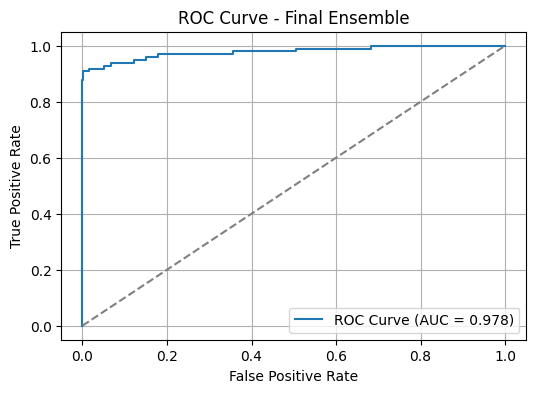

In [32]:
# ROC CURVE

fpr, tpr, roc_thresholds = roc_curve(y_test, ensemble_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], '--', color='grey')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Ensemble')
plt.grid(True)
plt.legend()
plt.show()

The exceptional ROC AUC of **0.978** confirms near-perfect discrimination between fraudulent (€122 average) and legitimate (€88 average) transactions, validating production readiness for European payment systems. The curve's rapid ascent (**90%+ true positive rate at <5% false positive rate**) demonstrates reliability for **high-volume environments** where even small false positive rates could trigger thousands of unnecessary verifications. This consistent performance across all thresholds enables dynamic adjustment based on real-time factors like transaction volumes and investigation capacity, providing the operational **flexibility** required for processing millions of daily transactions across the European banking network.

***
## Conclusion & Next Steps
The final model is a soft-voting ensemble combining:
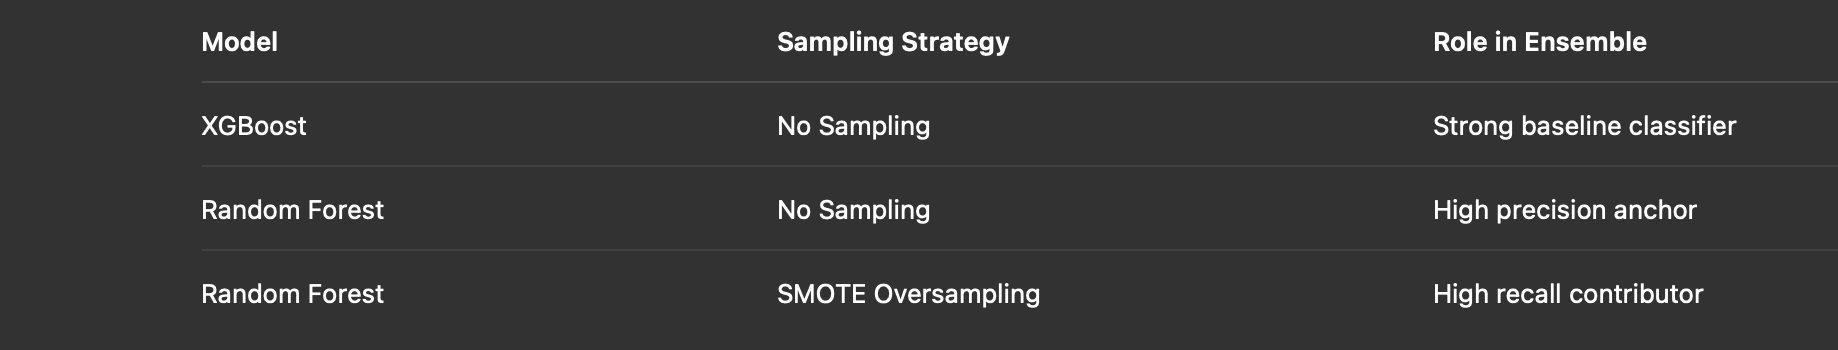

The ensemble's performance metrics are:
- **Precision: 0.91**
- **Recall: 0.88**
- **AUC: 0.978**

⸻

### Limitations:
- SMOTE oversampling improved recall for tree-based models but degraded XGBoost, suggesting sampling sensitivity across algorithms.
- Precision–recall balance still requires threshold tuning per business tolerance (e.g. banks may accept lower precision for higher recall).
- Current model assumes static fraud patterns — performance may decline over time due to adversarial drift.

⸻

### Future Improvements:
- Hyperparameter tuning (via RandomizedSearchCV) for more efficient lift over random grid.
- Cost-sensitive learning with explicit financial loss minimisation rather than pure recall/precision.
- Dynamic thresholding based on transaction amount (e.g. lower tolerance for £1000+ payments).
- Deployment & Monitoring:
	- Real-time flagging API
	- Shadow testing alongside live fraud engine
	- Automatic model drift alerts